### Introduction ###

There are four decoders included in the **replay_trajectory_classification** package:
+ `SortedSpikesDecoder`
+ `ClusterlessDecoder`
+ `SortedSpikesClassifier`
+ `ClusterlessClassifier`.

You can import them for use by running the following lines of code:

In [1]:
from replay_trajectory_classification import (SortedSpikesDecoder, ClusterlessDecoder,
                                              SortedSpikesClassifier, ClusterlessClassifier)

If `Decoder` is in the name it indicates that a single movement model is used to decode position.

If `Classifier` is in the name it means that multiple movement models are used to decode position and classify the type of movement.

`SortedSpikes` and `Clusterless` indicate the type of data the decoder uses:
+ `SortedSpikes` means the decoder takes in clustered single unit data.
+ `Clusterless` means the decoder takes in unsorted multiunit spikes and associated spike waveform features---like those that would usually be used to spike sort such as spike width, spike amplitude, etc.


Next, we will explore the expected data format for `SortedSpikes` and `Clusterless` decoders in turn. The both the `Decoder` and `Classifier` take the same data format.

### Sorted Spikes Data Format ###

We can see from the docstring of the fit function of `SortedSpikesDecoder` that there are two main variables that are required:
+ **position** - the 1D or 2D position of the animal at each time bin
+ **spikes** - 0 if there is no spike and 1 if there is a spike for each cell for each time bin

**NOTE**: Time bins should be small (typically 1 or 2 ms)

In [2]:
SortedSpikesDecoder.fit?

Signature:
SortedSpikesDecoder.fit(
    self,
    position,
    spikes,
    is_training=None,
    is_track_interior=None,
    track_graph=None,
    center_well_id=None,
    edge_order=None,
    edge_spacing=15,
)
Docstring:
Parameters
----------
position : ndarray, shape (n_time, n_position_dims)
spikes : ndarray, shape (n_time, n_neurons)
is_training : None or bool ndarray, shape (n_time), optional
    Time bins to be used for encoding.
is_track_interior : None or bool ndaarray, shape (n_x_bins, n_y_bins)
track_graph : networkx.Graph
center_well_id : object
edge_order : array_like
edge_spacing : None, float or array_like

Returns
-------
self
File:      ~/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      function


#### Example Data #### 
Let's look at some simulated data to get an intuition for these data types. We simulate spikes of 19 cells with 360,000 time bins (360 seconds) of data:

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

We can see that this numpy array is a matrix with time bins in the first dimension and cells on the second dimension

In [4]:
spikes.shape

(360000, 19)

and that there is a 1 each time a cell spikes and a 0 each time there is not a spike. For example, for the first cell, there is only one spike at 17 ms in the first 100 ms of time:

In [5]:
spikes[:100, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We can visualize the spikes as a spike raster:

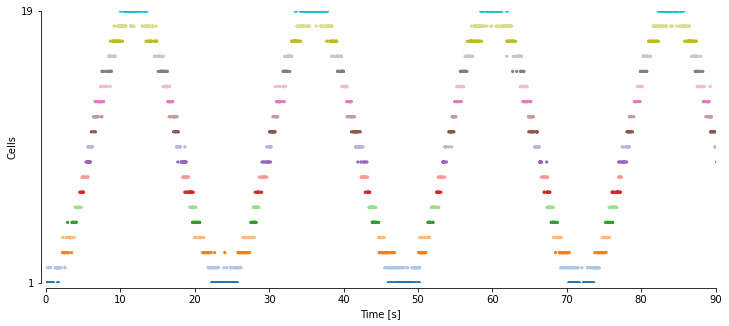

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

c = [cmap.colors[ind] for ind in neuron_ind]
ax.scatter(time[spike_ind], neuron_ind + 1, c=c, s=5)
ax.set_yticks((1, spikes.shape[1]))
ax.set_ylim((1, spikes.shape[1]))
ax.set_ylabel('Cells')

ax.set_xlabel('Time [s]')
ax.set_xlim((0.0, 90.0))
sns.despine(offset=5)

We also have a position variable which has the same number of time points and has one position dimension:

In [7]:
position.shape

(360000,)

We can plot position over time:

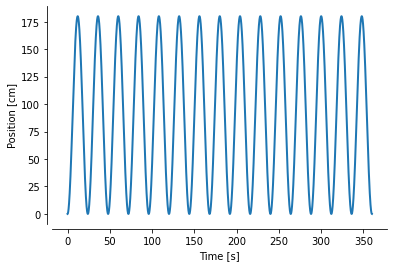

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time, position, linewidth=2)
ax.set_ylabel("Position [cm]")
ax.set_xlabel("Time [s]")
sns.despine(offset=5)

#### Summary ####
So we have two numpy arrays that contain the data we need to fit and evaluate the model:

In [9]:
spikes.shape

(360000, 19)

In [10]:
position.shape

(360000,)

### Clusterless Data Format ###

The `Clusterless` decoders take the same information as the `SortedSpikes` decoders with one exception: the actual multiunit spikes and their associated waveform features. This variable is called **multiunits** and it has time bins on the first dimension, the marks (or associated wave form features) in the second dimension, and the electrodes in the last dimension.

In [11]:
ClusterlessDecoder.fit?

Signature:
ClusterlessDecoder.fit(
    self,
    position,
    multiunits,
    is_training=None,
    is_track_interior=None,
    track_graph=None,
    center_well_id=None,
    edge_order=None,
    edge_spacing=15,
)
Docstring:
Parameters
----------
position : array_like, shape (n_time, n_position_dims)
multiunits : array_like, shape (n_time, n_marks, n_electrodes)
is_training : None or array_like, shape (n_time,)
is_track_interior : None or ndarray, shape (n_x_bins, n_y_bins)
track_graph : networkx.Graph
center_well_id : object
edge_order : array_like
edge_spacing : None, float or array_like

Returns
-------
self
File:      ~/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      function


#### Example Data ####

For the multiunits array, if there is no spike in a particular time bin, there are only NaNs. If there is a spike, then the values of the associated waveform feature are filled in. Let's loook at some example simulated data:

In [12]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, position, sampling_frequency,
 multiunits, _) = make_simulated_run_data()

We can see that there are 350,000 time bins, 4 mark dimensions (wave form features), and 5 electrodes:

In [13]:
multiunits.shape

(350000, 4, 5)

If we look at the first electrode, we see that there is a spike in the first time bin and then no spike for the next 9 time bins (hence they are filled with NaNs):

In [14]:
multiunits[:10, :, 0]

array([[        nan,         nan,         nan,         nan],
       [-0.72414964, -0.13129719,  0.7648122 , -0.22578798],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan]])

These four values represent waveform features of this electrode at the time of the spike. Likewise, if we look at the second electrode, we can see that there was no spike in the first 10 time bins.

In [15]:
multiunits[:10, :, 1]

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

### Track Graph ###

If you are using 1D position but want to represent an environment more complicated than a linear track, you need to constract a graph representation of the track that indicates how the 1D position can connect. We refer to this as the **track_graph**. This is done using the NetworkX package. First we define some helper functions:

In [44]:
import networkx as nx

def make_track_graph(node_positions, edges):
    '''Constructs a graph representation of a 2D track.

    Node positions determine the name of the node by order in array.
    Edges determine the connections between the nodes by name.

    Parameters
    ----------
    node_positions : numpy.ndarray, shape (n_nodes, 2)
    edges : numpy.ndarray, shape (n_edges, 2)

    Returns
    -------
    track_graph : networkx.Graph

    '''
    track_graph = nx.Graph()

    for node_id, node_position in enumerate(node_positions):
        track_graph.add_node(node_id, pos=tuple(node_position))

    for edge in edges:
        node1, node2 = edge
        pos1 = np.asarray(track_graph.nodes[node1]["pos"])
        pos2 = np.asarray(track_graph.nodes[node2]["pos"])
        distance = np.linalg.norm(pos1 - pos2)
        nx.add_path(track_graph, edge, distance=distance)

    return track_graph


def plot_track_graph(track_graph, ax=None, draw_edge_labels=False, **kwds):
    '''

    Parameters
    ----------
    track_graph : networkx Graph

    '''
    node_position = nx.get_node_attributes(track_graph, 'pos')
    nx.draw_networkx(track_graph, node_position, ax, **kwds)

    if draw_edge_labels:
        edge_ids = {edge: ind for ind, edge in enumerate(track_graph.edges)}
        nx.draw_networkx_edge_labels(track_graph, node_position,
                                     edge_labels=edge_ids)

Now we define the x- and y-position of the nodes. The nodes are automatically named by their order:
+ node "0" has position (0, 0)
+ node "1" has position (1, 0)
+ node "2" has position (1, 1)
+ node "3" has position (0, 1)

In [179]:
node_positions = [(0, 0), # xy position of node 0
                  (1, 0), # xy position of node 1
                  (1, 1), # xy position of node 2
                  (0, 1), # xy position of node 3
                 ]

Then we can define how the nodes are connected by their node names. So if we want node "0" and node "1" to be connected, then we specify (0, 1)

In [180]:
edges = [(0, 1), # connects node 0 and node 1
         (1, 2), # connects node 1 and node 2
         (2, 3), # connects node 2 and node 3
        ]

Then we can construct a graph of the track by using the function `make_track_graph`, which will return a NetworkX Graph object:

In [181]:
track_graph = make_track_graph(node_positions, edges)

track_graph

In [182]:
track_graph.nodes

NodeView((0, 1, 2, 3))

In [183]:
track_graph.edges

EdgeView([(0, 1), (1, 2), (2, 3)])

We can visualize the **track_graph** by using our `plot_track_graph` function:

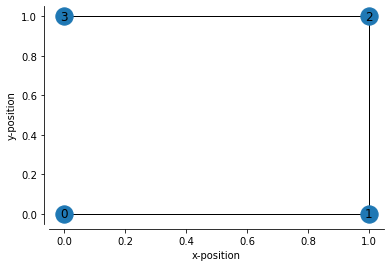

In [184]:
fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

We can change how these points are connected by changing the edges:

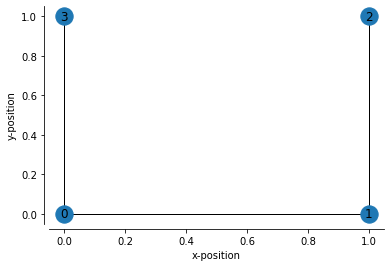

In [185]:
edges = [(0, 1), # connects node 0 and node 1
         (0, 3), # connects node 0 and node 3
         (1, 2), # connects node 1 and node 2
        ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

We could also change the node positions:

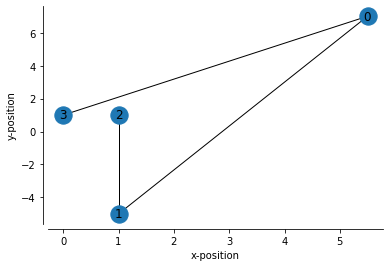

In [186]:
node_positions = [(5.5, 7), # xy position of node 0
                  (1, -5), # xy position of node 1
                  (1, 1), # xy position of node 2
                  (0, 1), # xy position of node 3
                 ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

Also note that the edges also have names. These are also based on the order in the array of edges. This will become important in specify ***edge order*** later. We can visualize these as well by setting `draw_edge_labels=True`:

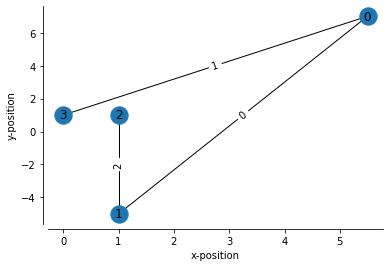

In [187]:
fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

There are three other parameters when using `track_graph` with the decoders. These specify how the edges correspond to 1D position:
+ **center_well_id** -- This is the name of the node that corresponds to position 0 in 1D position
+ **edge_order** -- The order of the edges in 1D position in terms of their edge names.
+ **edge_spacing** -- The spacing between the edges. This is necessary when edges are not connected to each other in 2D space, because the smoothing used by the model will inappropriately smooth into a non-adjacent edge. This will always be one less than the number of edges.


For example, we might linearize the above track as:

Text(0.5, 0, 'Linear Position [cm]')

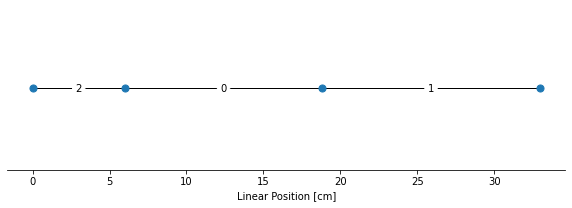

In [193]:
linear_node_positions = [(track_graph.edges[1, 2]["distance"] + track_graph.edges[0, 1]["distance"], 0), # xy position of node 0
                         (track_graph.edges[1, 2]["distance"], 0), # xy position of node 1
                         (0, 0), # xy position of node 2
                         (track_graph.edges[1, 2]["distance"] + track_graph.edges[0, 1]["distance"] + track_graph.edges[1, 2]["distance"] + track_graph.edges[0, 3]["distance"], 0), # xy position of node 3
                        ]

linearized_track_graph = make_track_graph(linear_node_positions, edges)

fig, ax = plt.subplots(figsize=(10, 3))
plot_track_graph(linearized_track_graph, ax=ax, draw_edge_labels=True, node_size=50, with_labels=False)
sns.despine(bottom=False, left=True)
ax.tick_params(bottom=True, labelbottom=True)
ax.set_xlabel("Linear Position [cm]")

The center well is 2 because it is at position 0 in the 1D space. The edge order is [2, 0, 1] because that is how the edges are arranged in 1D space. The edge spacing can be zero, because edge 2 is next to edge 0 and edge 0 is next to edge 1.

In [195]:
center_well_id = 2
edge_order = [2, 0, 1]
edge_spacing = [0, 0]

But let's try a more complicated track:

(-1.1, 1.1, -0.05, 1.05)

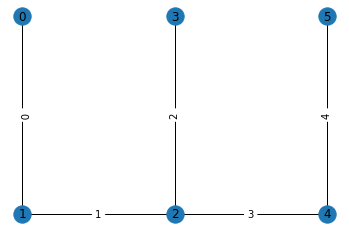

In [196]:
node_positions = [(-1, 1), # xy position of node 0
                  (-1, 0), # xy position of node 1
                  (0, 0), # xy position of node 2 *
                  (0, 1), # xy position of node 3
                  (1, 0), # xy position of node 4
                  (1, 1), # xy position of node 5
                 ]

edges = [(0, 1), # connects node 0 and node 1
         (1, 2), # connects node 1 and node 2
         (2, 3), # connects node 2 and node 3
         (2, 4), # connects node 2 and node 4
         (4, 5), # connects node 4 and node 5
        ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.axis("off")

In this case, the edge 2 (between nodes 2 and 3) has to be placed separately from the other edges in 1D position, so a gap is needed. One possible scheme would be:

In [197]:
center_well_id = 3
edge_order = [2, 1, 0, 3, 4]
edge_spacing = [0, 0, 5, 0]

The edge spacing is 0 between edges 2 and edges 1 because they are connected. Likewise the edge spacing is 0 between edges 1 and 0 because they are connected.

**Importantly**, the edge spacing between edges 0 and 3 is 15 because edge 0 and 3 are not directly connected.

The edge spacing between edge 3 and edge 4 is 0 because they are connected. We can visualize this as follows:

Text(0.5, 0, 'Linear Position [cm]')

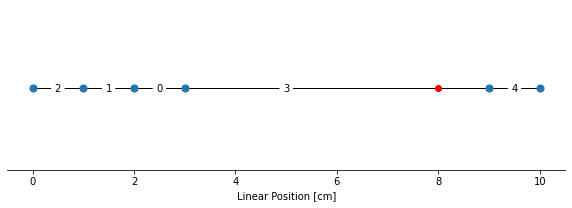

In [206]:
linear_node_positions = [(track_graph.edges[3, 2]["distance"] + track_graph.edges[2, 1]["distance"] + track_graph.edges[1, 0]["distance"], 0), # xy position of node 0
                         (track_graph.edges[3, 2]["distance"] + track_graph.edges[2, 1]["distance"], 0), # xy position of node 1
                         (track_graph.edges[3, 2]["distance"], 0), # xy position of node 2 *
                         (0, 0), # xy position of node 3
                         (track_graph.edges[3, 2]["distance"] + track_graph.edges[2, 1]["distance"] + track_graph.edges[1, 0]["distance"] + track_graph.edges[2, 4]["distance"] + 5, 0), # xy position of node 4
                         (track_graph.edges[3, 2]["distance"] + track_graph.edges[2, 1]["distance"] + track_graph.edges[1, 0]["distance"] + track_graph.edges[2, 4]["distance"] + 5 + track_graph.edges[4, 5]["distance"], 0), # xy position of node 5
                 ]

linearized_track_graph = make_track_graph(linear_node_positions, edges)

fig, ax = plt.subplots(figsize=(10, 3))
plot_track_graph(linearized_track_graph, ax=ax, draw_edge_labels=True, node_size=50, with_labels=False)
ax.set_xlim((-0.5, 10.5))
ax.set_ylim((-0.25, 0.25))
sns.despine(bottom=False, left=True)
ax.tick_params(bottom=True, labelbottom=True)
ax.scatter(8, 0, zorder=100, color="red")
ax.set_xlabel("Linear Position [cm]")

In [203]:
linear_node_positions

[(3.0, 0), (2.0, 0), (1.0, 0), (0, 0), (9.0, 0), (10.0, 0)]

In [110]:
nx.draw_networkx?

Signature: nx.draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
Docstring:
Draw the graph G using Matplotlib.

Draw the graph with Matplotlib with options for node positions,
labeling, titles, and many other drawing features.
See draw() for simple drawing without labels or axes.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary, optional
   A dictionary with nodes as keys and positions as values.
   If not specified a spring layout positioning will be computed.
   See :py:mod:`networkx.drawing.layout` for functions that
   compute node positions.

arrows : bool, optional (default=True)
   For directed graphs, if True draw arrowheads.
   Note: Arrows will be the same color as edges.

arrowstyle : str, optional (default='-|>')
    For directed graphs, choose the style of the arrowsheads.
    See :py:class: `matplotlib.patches.ArrowStyle` for more
    options.

arrowsize : int, optional (default=10)
   For directed graphs, choose the size of the arrow 